In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# %matplotlib nbagg
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import rcParams  # Para aumentar la resolución de los gráficos de Matplot
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams["font.size"] = 14
rcParams['figure.figsize'] = (12, 6)
rcParams['figure.dpi'] = 100
plt.style.use('seaborn-dark-palette')

Primero cargamos los datos y metemos las coordenadas y las velocidades en una lista.

In [2]:
# Field = [] 
f = np.load("destilada_lento.npz")
# Field.append(f)

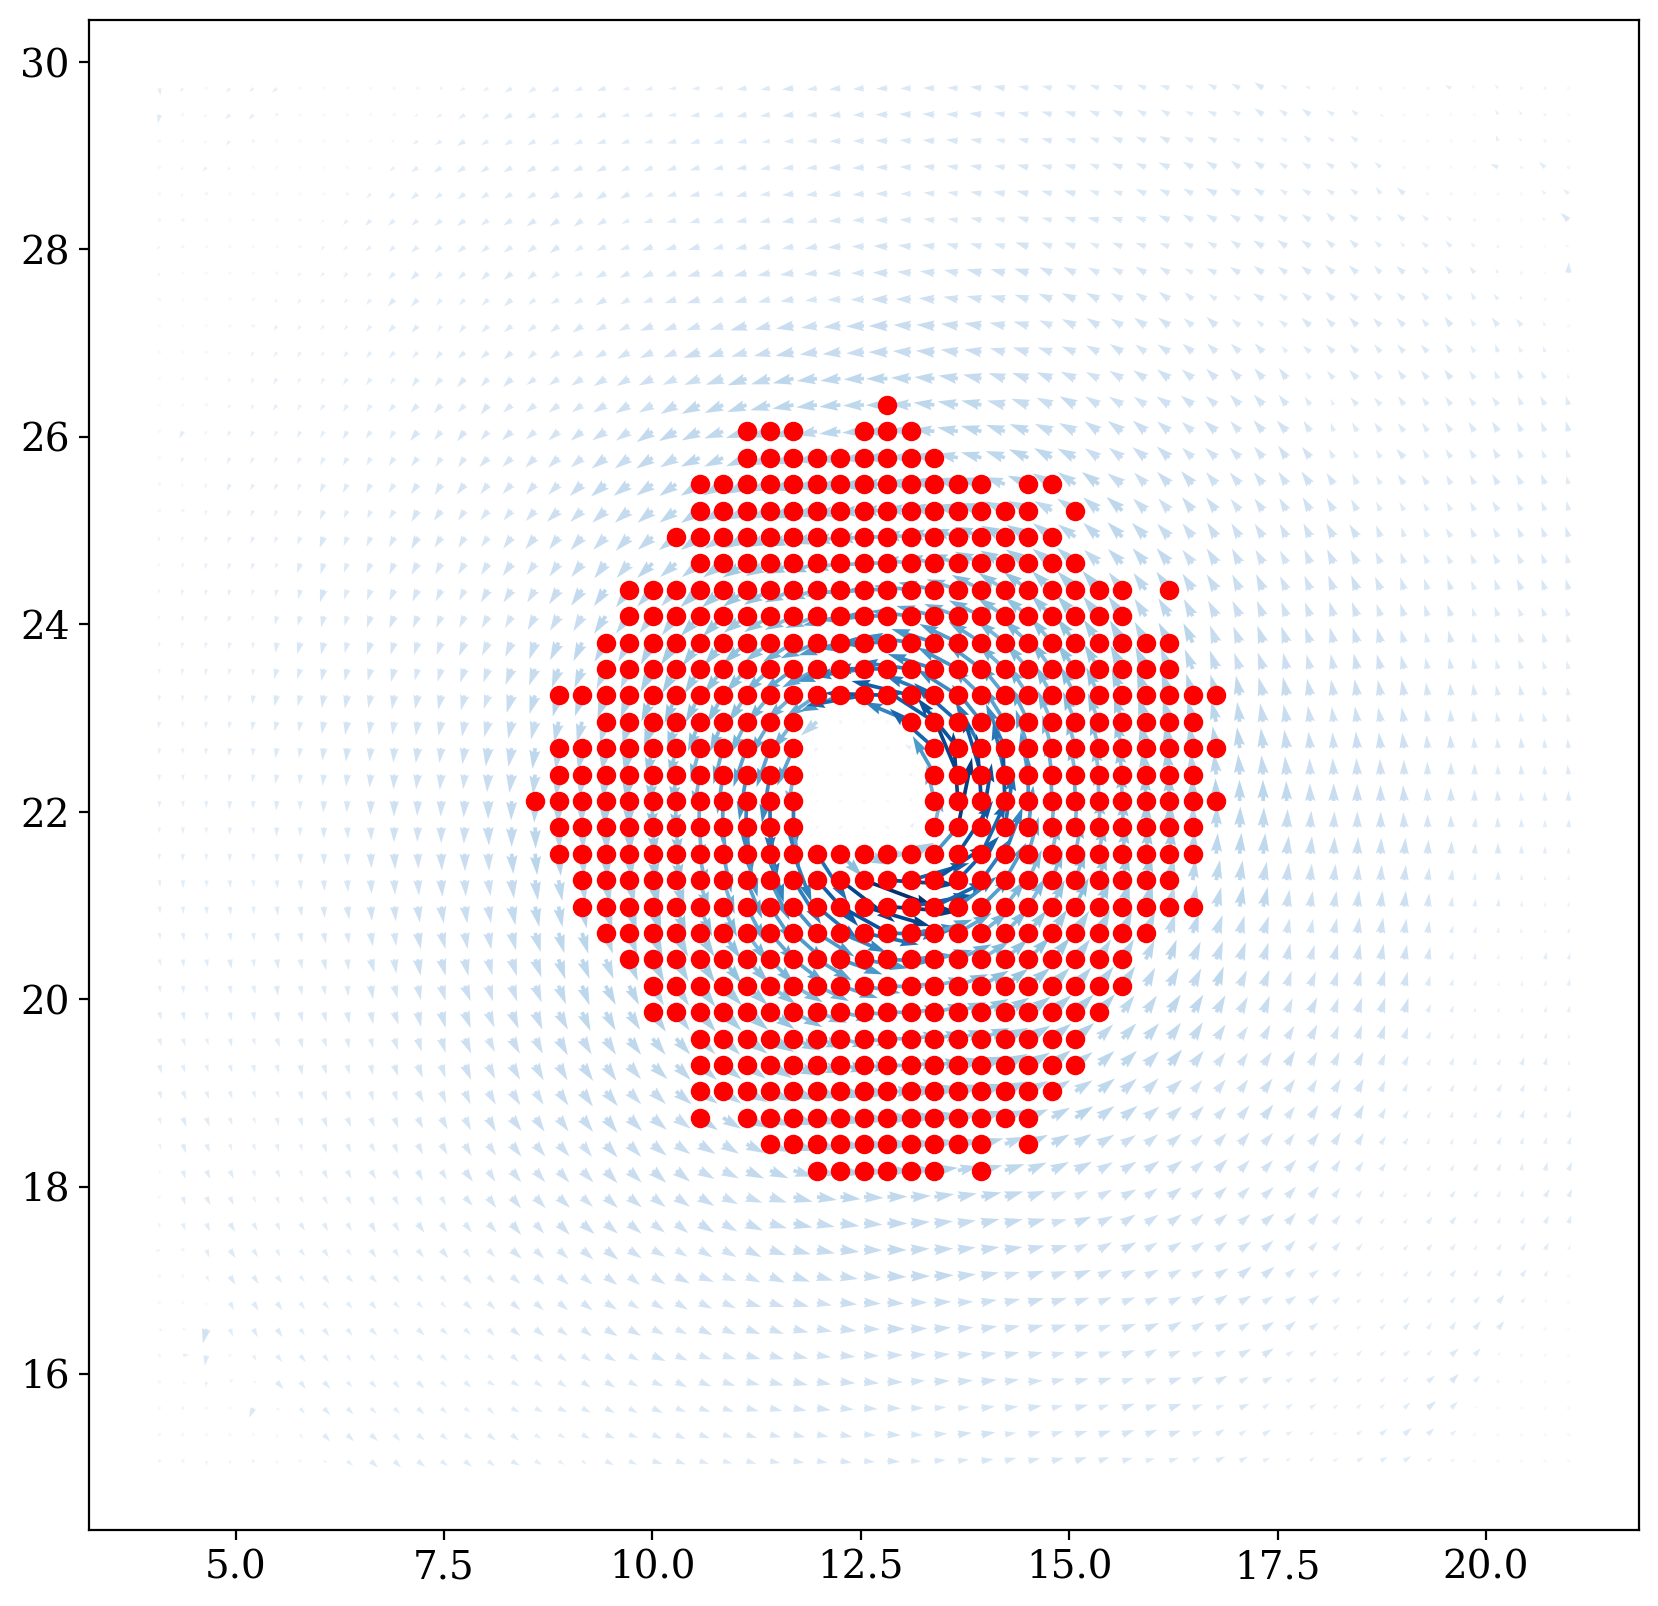

In [3]:
# Definimos las coordenadas y las velocidades
x = f['arr_0'].reshape(f['arr_0'].shape[0]*f['arr_0'].shape[1]) #Field[0][:,0]
y = f['arr_1'].reshape(f['arr_1'].shape[0]*f['arr_1'].shape[1]) #Field[0][:,1]
u = f['U'].reshape(f['U'].shape[0]*f['U'].shape[1]) #Field[0][:,2]
v = f['V'].reshape(f['V'].shape[0]*f['V'].shape[1]) #Field[0][:,3]
err_u = f['Uerr'].reshape(f['Uerr'].shape[0]*f['Uerr'].shape[1])
err_v = f['Verr'].reshape(f['Verr'].shape[0]*f['Verr'].shape[1])

# recorte de la imagen:
min_x = 4
max_x = 21
min_y = 15
max_y = 30

idx_recorte = np.array([i for i in range(len(x)) if (x[i]>min_x and x[i]<max_x) and (y[i]>min_y and y[i]<max_y)])
x = x[idx_recorte]
y = y[idx_recorte]
u = u[idx_recorte]
v = v[idx_recorte]
err_u = err_u[idx_recorte]
err_v = err_v[idx_recorte]

color = np.hypot(u, v)
color=(color-min(color))/(max(color)-min(color))
C=plt.cm.Blues(color)

# # Hacemos un gráfico para visualizar el campo de velocidades
fig, ax = plt.subplots(1,1, figsize=(10,10))
# img = mpimg.imread("destilada con colorante glitter\destilada oscura dos filtros\imagenes\\0001.jpg")
# ax.imshow(img)
Q = ax.quiver(x,y,u,v, color=C)

# Seleccionamos los puntos que utilizaremos para calcular el centro (filtramos con un mínimo de velocidad):
v_threshold = 15

idx = np.array([i for i in range(len(x)) if (u[i]**2 + v[i]**2) > v_threshold])
x_sel = x[idx]
y_sel = y[idx]
u_sel = u[idx]
v_sel = v[idx]
ax.scatter(x_sel, y_sel, c='r')
plt.show()

Para calcular el centro, se grafican para un conjunto de puntos las rectas perpendiculares a sus velocidades, que se cruzarán en el centro del vórtice si las velocidades son tangenciales. Para esto se calcula la pendiente utilizando el ángulo theta formado entre la velocidad y la dirección horizontal, y la ordenada al origen a partir de pedir que la recta pase por el punto, de coordenadas (x,y). Luego se buscan los puntos de intersección entre todo par de rectas y se calcula el valor medio de todos ellos, donde se determina el centro de coordenadas.

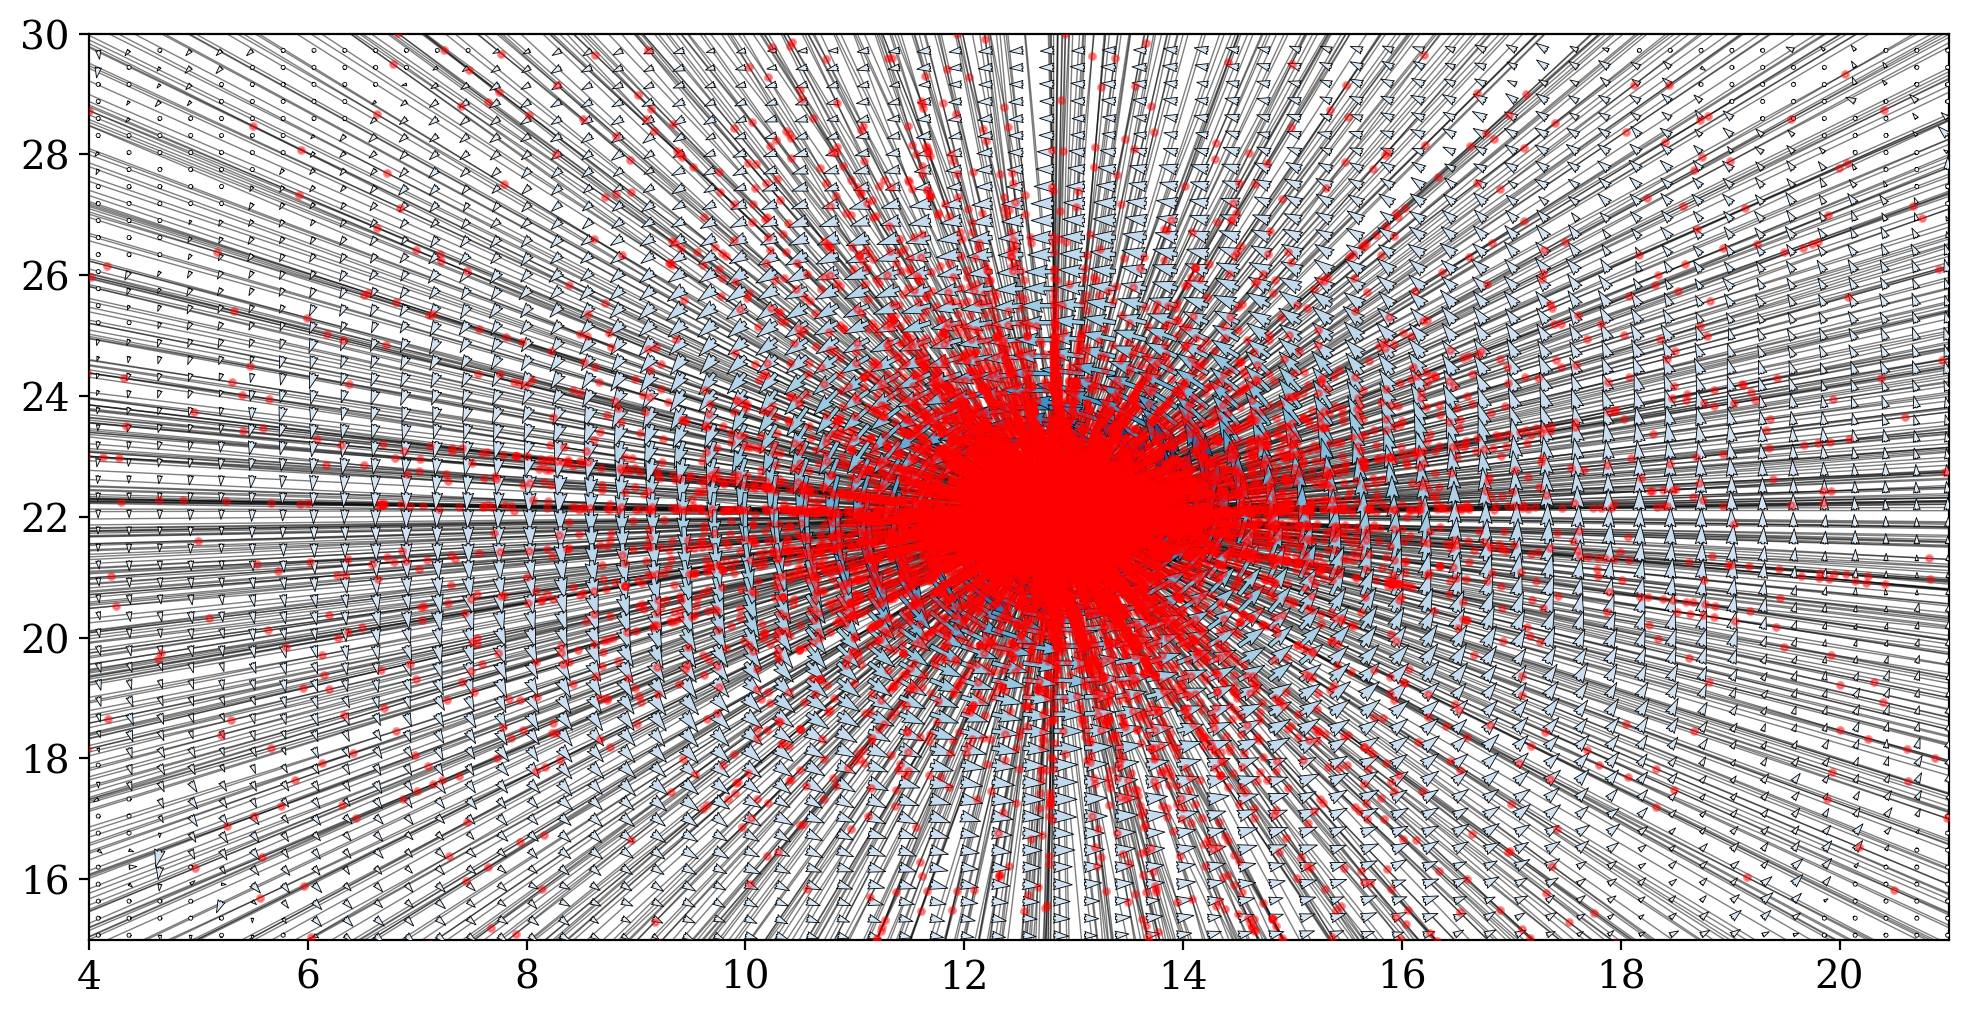

In [7]:
theta = np.arctan(v_sel/u_sel) # ángulos que forma el vector velocidad con la horizontal

# calculo las rectas de cada punto que contienen al vector posición medido desde el centro:
m = np.tan(theta-np.pi/2) # pendientes
b = y_sel - m*x_sel # ordenadas al origen

# F = [] # acá almacenaremos todas las rectas
# for i in range(len(x_sel)):
#     f = lambda X: m[i]*X + b[i] # ecuación de la recta de un solo punto
#     F.append(f)

# Buscamos los puntos de intersección entre todas las rectas:

# dónde guardaremos las coordenadas de los puntos de intersección:
X_intercept = []
Y_intercept = []
for i in range(len(x_sel)):
    m1 = m[i]
    b1 = b[i]
    for j in range(i+1,len(x_sel)):
        m2 = m[j]
        b2 = b[j]
        x_intercept = (b2-b1)/(m1-m2)
        y_intercept = x_intercept*m1 + b1
        X_intercept.append(x_intercept)
        Y_intercept.append(y_intercept)

# graficamos todas las rectas y los puntos de intersección:
fig, ax = plt.subplots()
X_lin = np.linspace(min_x,max_x,10) # vector de valores de x para graficar
for i in range(len(x_sel)):
    ax.plot(X_lin, m[i]*X_lin + b[i], c='k', lw=.5, alpha=.5)
ax.scatter(X_intercept, Y_intercept, c='r', s=5, alpha=.4, zorder=5)
ax.set_ylim(min_y,max_y)
ax.set_xlim(min_x,max_x)
ax.quiver(x,y,u,v, color=C, edgecolor='k', linewidth=.3, zorder=3)
plt.show()

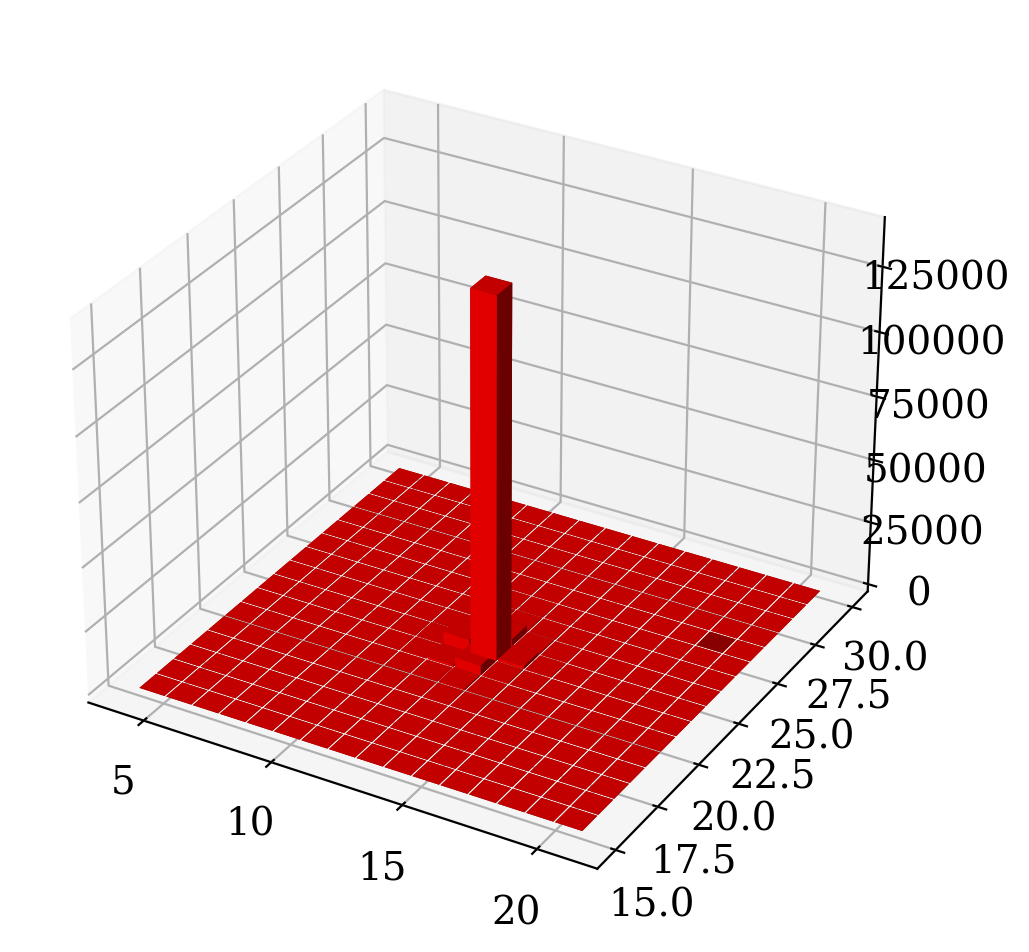

In [43]:
# histograma 3D de los puntos de intersección:

bins = 16

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(X_intercept, Y_intercept, bins=bins, range=[[min_x,max_x],[min_y,max_y]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.4/bins, yedges[:-1] + 0.4/bins, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = ((max_x - min_x)/(bins+1)) * np.ones_like(zpos)
dy = ((max_y - min_y)/(bins+1)) * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color='red')

plt.show()

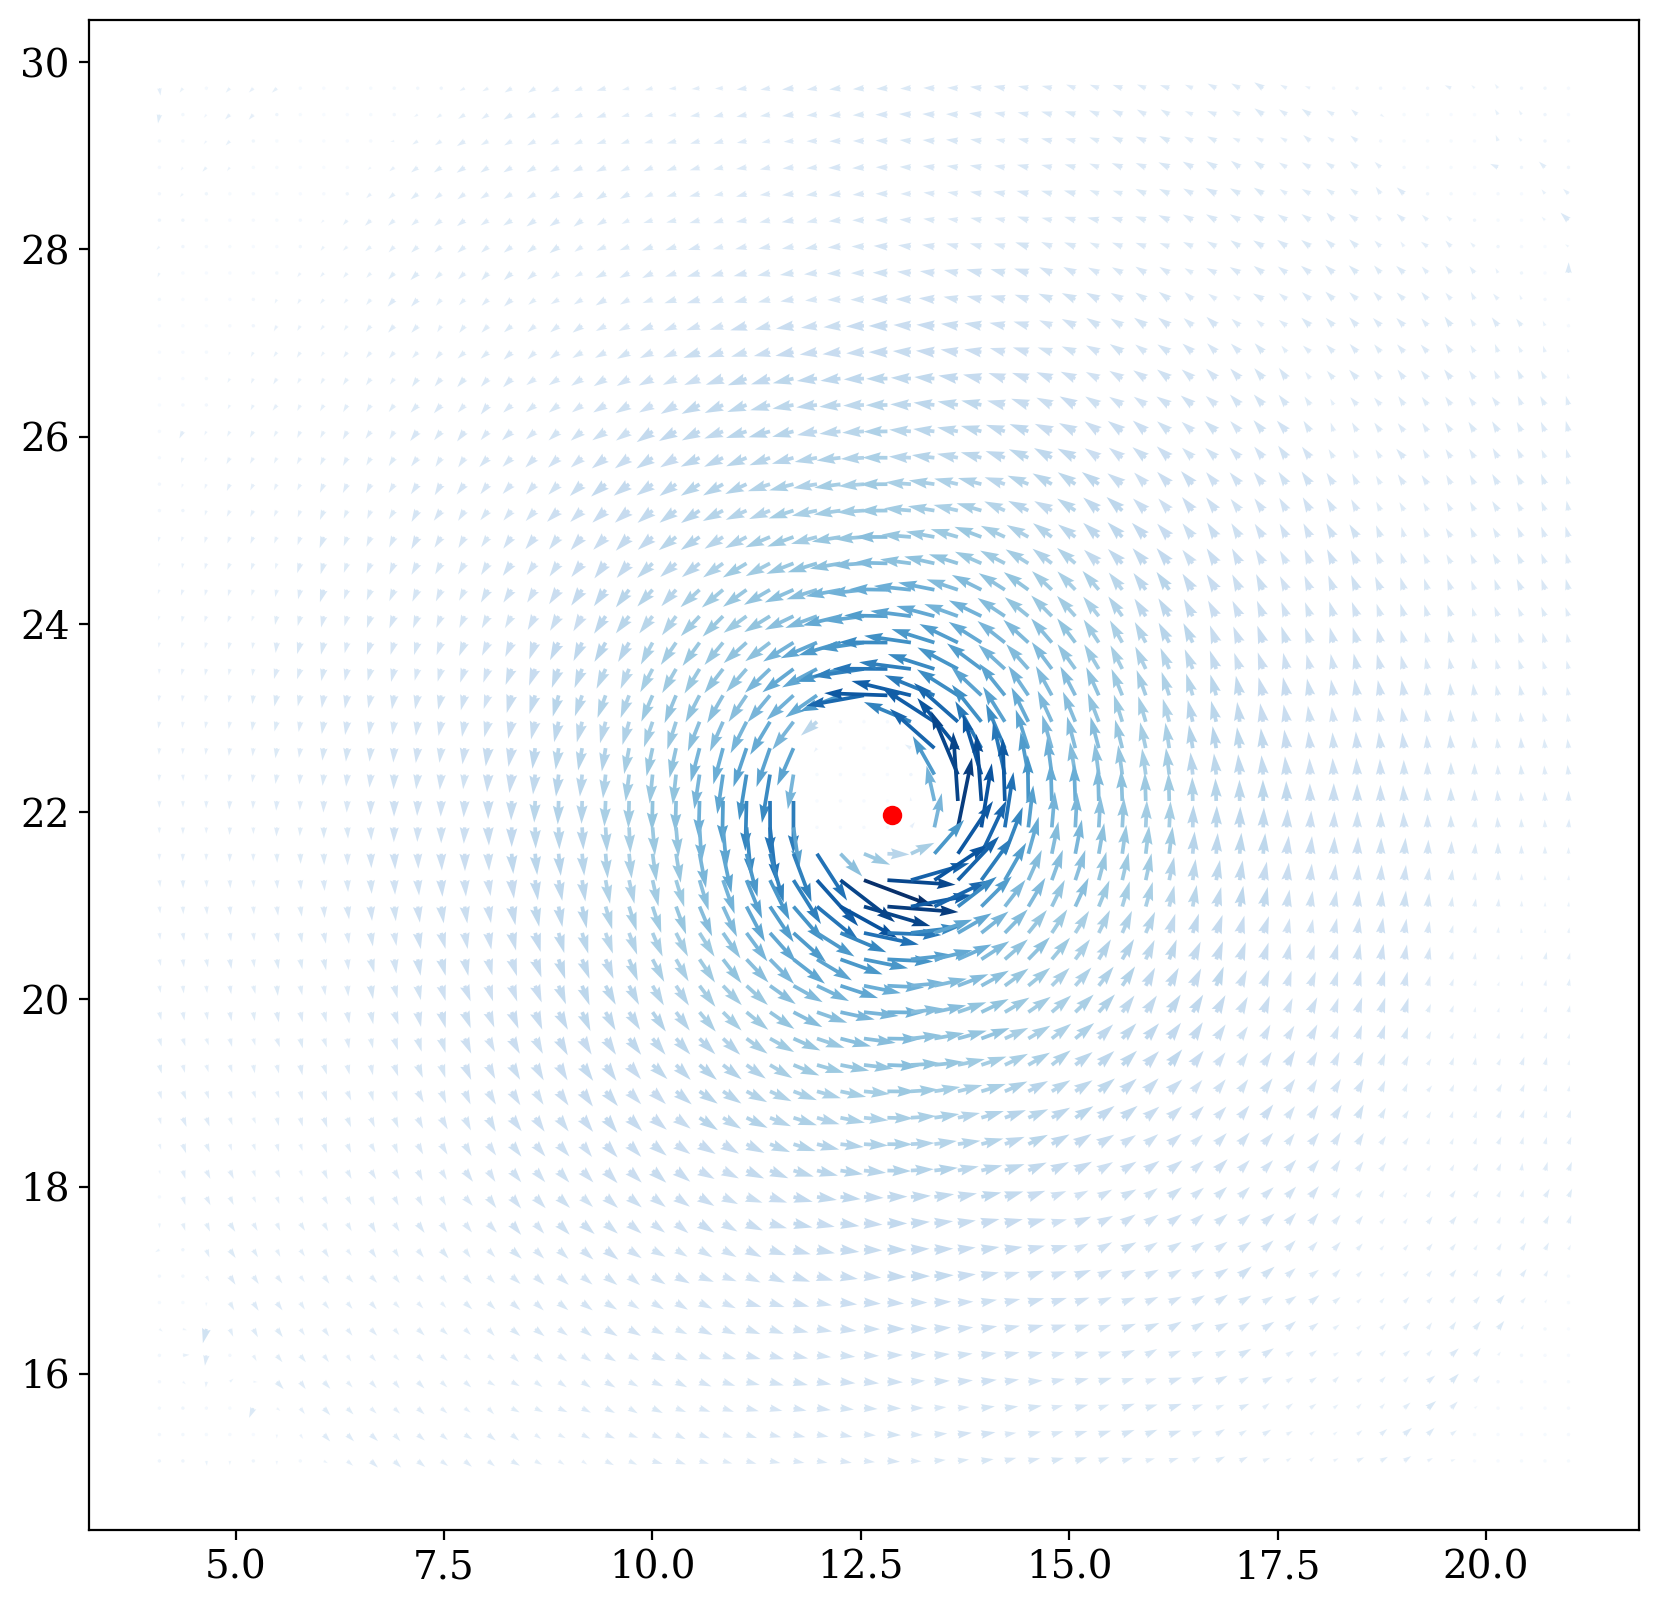

In [45]:
# Finalmente, buscamos el centro como el punto medio de todas las intersecciones, y lo graficamos:

X_centro = np.mean(X_intercept)
Y_centro = np.mean(Y_intercept)
err_x_centro = np.std(X_intercept)
err_y_centro = np.std(Y_intercept)


fig, ax = plt.subplots(figsize=(10,10))
ax.quiver(x,y,u,v, color=C)
ax.scatter(X_centro, Y_centro, c='r')
plt.show()

Gráfico de la posición del centro en función del valor del v_threshold:

C:\Users\nicof\AppData\Local\Temp\ipykernel_27688\3710829320.py:13: RuntimeWarning: invalid value encountered in true_divide
  thetas = np.arctan(v_sorted/u_sorted) # ángulos que forma el vector velocidad con la horizontal
C:\Users\nicof\AppData\Local\Temp\ipykernel_27688\3710829320.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  x_intercept = (b2-b1)/(m1-m2)


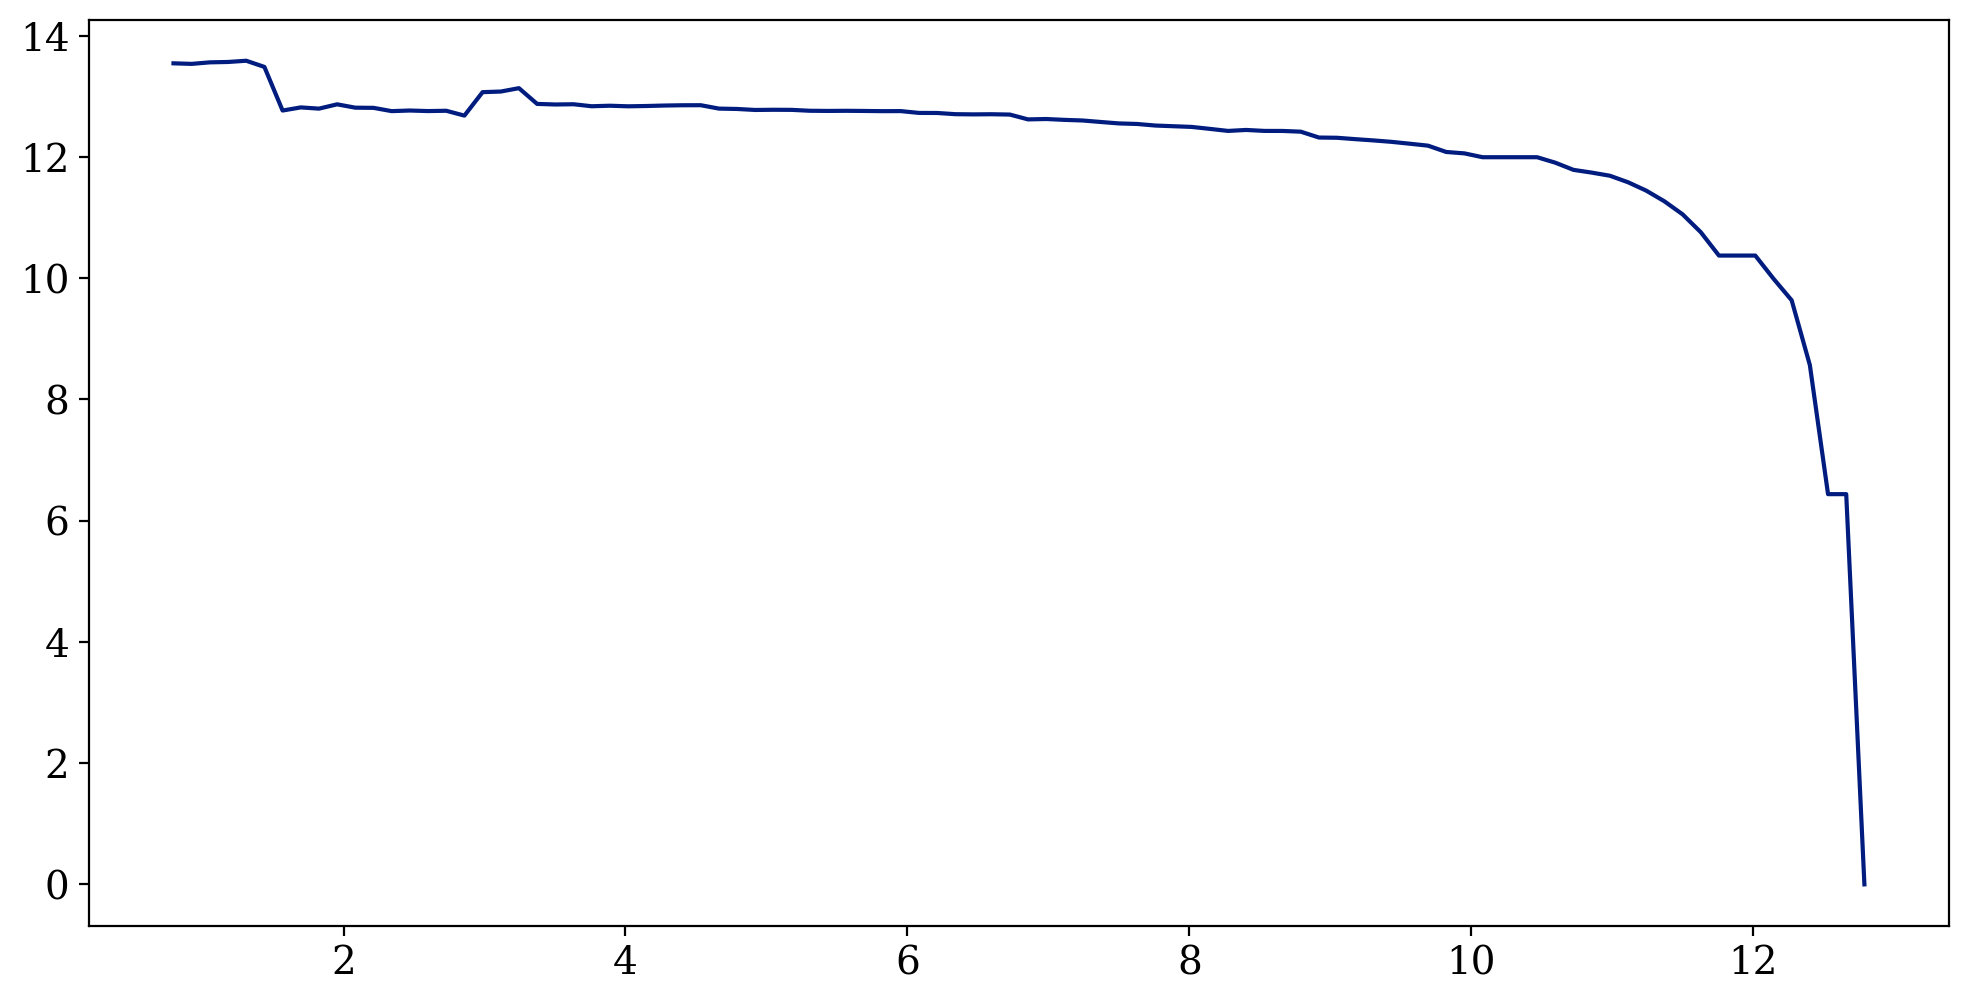

In [35]:
# ordenamos los puntos y sus velocidades según el módulo de su velocidad:
v_abs = np.hypot(u, v)
idx_sort = np.argsort(v_abs)
x_sorted = x[idx_sort]
y_sorted = y[idx_sort]
u_sorted = u[idx_sort]
v_sorted = v[idx_sort]
v_abs = v_abs[idx_sort]

# array con distintos valores del parámetro v_threshold
V_thresholds = np.linspace(v_abs[1], v_abs[-2], 100)

thetas = np.arctan(v_sorted/u_sorted) # ángulos que forma el vector velocidad con la horizontal

# calculo las rectas de cada punto que contienen al vector posición medido desde el centro:
ms = np.tan(thetas-np.pi/2) # pendientes
bs = y_sorted - ms*x_sorted # ordenadas al origen

# Buscamos los puntos de intersección entre todas las rectas:

# dónde guardaremos las coordenadas de los puntos de intersección:
X_intercept = np.zeros((len(x_sorted), len(x_sorted)))
Y_intercept = np.zeros((len(x_sorted), len(x_sorted)))

for i in range(len(x_sorted)):
    m1 = ms[i]
    b1 = bs[i]
    for j in range(i+1,len(x_sorted)):
        m2 = ms[j]
        b2 = bs[j]
        x_intercept = (b2-b1)/(m1-m2)
        y_intercept = x_intercept*m1 + b1
        X_intercept[i,j] = x_intercept
        Y_intercept[i,j] = y_intercept

X_centros = []
Y_centros = []
X_centro_std = []
Y_centro_std = []
for v_threshold in V_thresholds:
    idx_sel = np.array([i for i in range(len(v_abs)) if v_abs[i] > v_threshold])
    x_sum = np.sum(X_intercept[idx_sel,:])
    y_sum = np.sum(Y_intercept[idx_sel,:])
    n_intersecs = len(idx_sel)*(len(idx_sel)+1)/2 # número de intersecciones
    x_mean = x_sum/n_intersecs
    y_mean = y_sum/n_intersecs
    X_centros.append(x_mean)
    Y_centros.append(y_mean)

plt.plot(V_thresholds, X_centros)
# plt.plot(V_thresholds, Y_centros)
    
   
   
            
    

Cálculo de errores:

In [46]:
x_corrido =x - X_centro
y_corrido = y - Y_centro

r = np.abs(x_corrido+1j*y_corrido)
theta = np.angle(x_corrido+1j*y_corrido)
v_r= (x_corrido*u+y_corrido*v)/r
v_theta = (x_corrido*v-y_corrido*u)/(r)

err_v_theta = np.abs(x_corrido)*err_v/r + np.abs(y_corrido)*err_u/r + np.abs(v/r + v_theta*x_corrido/(r**2))*err_x_centro + np.abs(v_theta*y_corrido/(r**2) - u/r)*err_y_centro


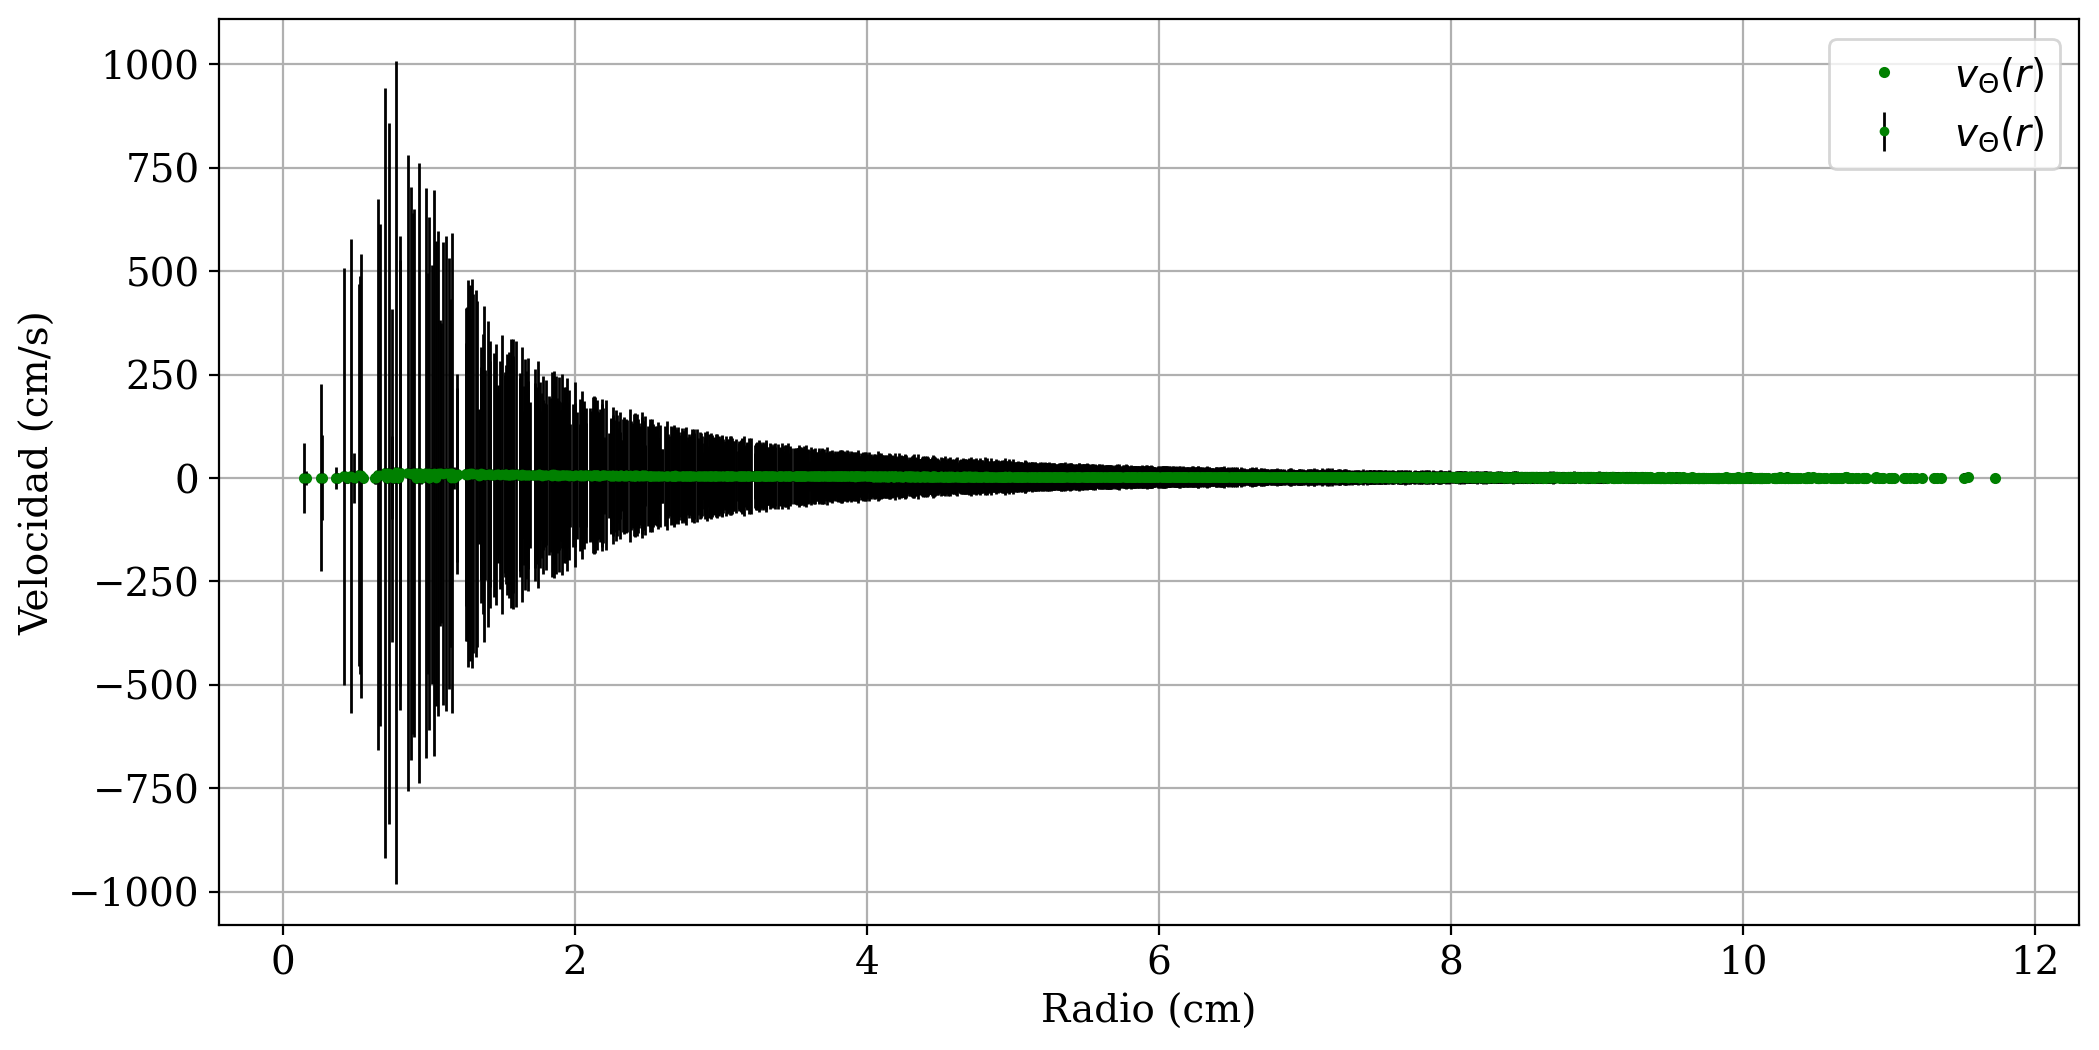

In [49]:
#plt.plot(r,v_r,".",label = "$v_{r}(r)$")
plt.plot(r,v_theta,".",label = "$ v_{\Theta} (r)$", color = "green")
plt.errorbar(r, v_theta, yerr=err_v_theta, fmt='.', c='green', ecolor='black', elinewidth=1, ms=5, label='$ v_{\Theta} (r)$')
plt.xlabel('Radio (cm)')
plt.ylabel('Velocidad (cm/s)')
plt.legend()
plt.grid()
# plt.savefig("Gráficos campo.png")
plt.show()

Ahora definimos las funciones con las que vamos a ajustar.

In [67]:
def rankine(x,omega,c): # Hay que chequearla porque no se si funciona bien
    f = []
    for i in x:
        if i < c:
            f.append(omega*i)
        else:
            f.append((omega*c**2)/i)
    return np.array(f)

def rankine2(x,omega,c):
    return np.piecewise(x,[x<c, x>=c], [lambda x: omega*x, lambda x: (omega*c**2)/x])

def burgers(x,a,b):
  return a*(1-np.exp(-(x/b)**2))/x

Ahora definimos una funcion para graficar varias veces sin tener que estar copiando el codigo todo el tiempo, que tome el modelo de Rankine o Burgers segun le pidamos y nos devuelva los parametros del ajuste.

In [82]:
def ajuste_sin_errores(f_ajuste,r,v_theta,mostrar_parametros = True):
    
    var_x = r
    var_y = v_theta
    
    popt, pcov = curve_fit(f_ajuste, var_x, var_y)#,sigma=err_y,absolute_sigma=True)#, p0 = [-200,0.3,250], maxfev=10000)#, absolute_sigma = True, sigma=err_var_y)
    a, b = popt
    err_a, err_b = np.sqrt(np.diag(pcov))
    
    # Declaramos nuestro nuevo dominio e imagen y graficamos el ajuste
    new_var_x = np.linspace(min(var_x), max(var_x), 10000)
    new_var_y = f_ajuste(new_var_x, a, b)
    
    # Graficamos los datos y el ajuste
    plt.plot(var_x,var_y, 'k.', label = '$v_{\Theta}(r)$')
    plt.plot(new_var_x, new_var_y, 'm-', label='Ajuste')
    # Título y labels
    plt.xlabel("Radio (cm)")
    plt.ylabel("Velocidad (cm/s)")
    plt.grid(True)
    plt.legend()
    plt.savefig('Ajuste promedio.png')
    plt.show()

    # Ahora defino omega y c (radio del vortice) segun el ajuste utilizado
    if mostrar_parametros:
        if f_ajuste == burgers:
            omega = a/(b**2)
            c = b
            err_omega = np.sqrt((err_a/(b**2))**2+(2*err_b*a/(b**3))**2)
            err_c = err_b

        if f_ajuste == rankine or f_ajuste == rankine2:
            omega = a
            c = b
            err_omega = err_a
            err_c = err_b

        print(f"La velocidad angular Omega es {round(omega,3)} con error {round(err_omega,3)}")
        print(f"El radio del vortice c es {round(c,3)} con error {round(err_c,4)}")
    
    return omega, err_omega, c, err_c, popt

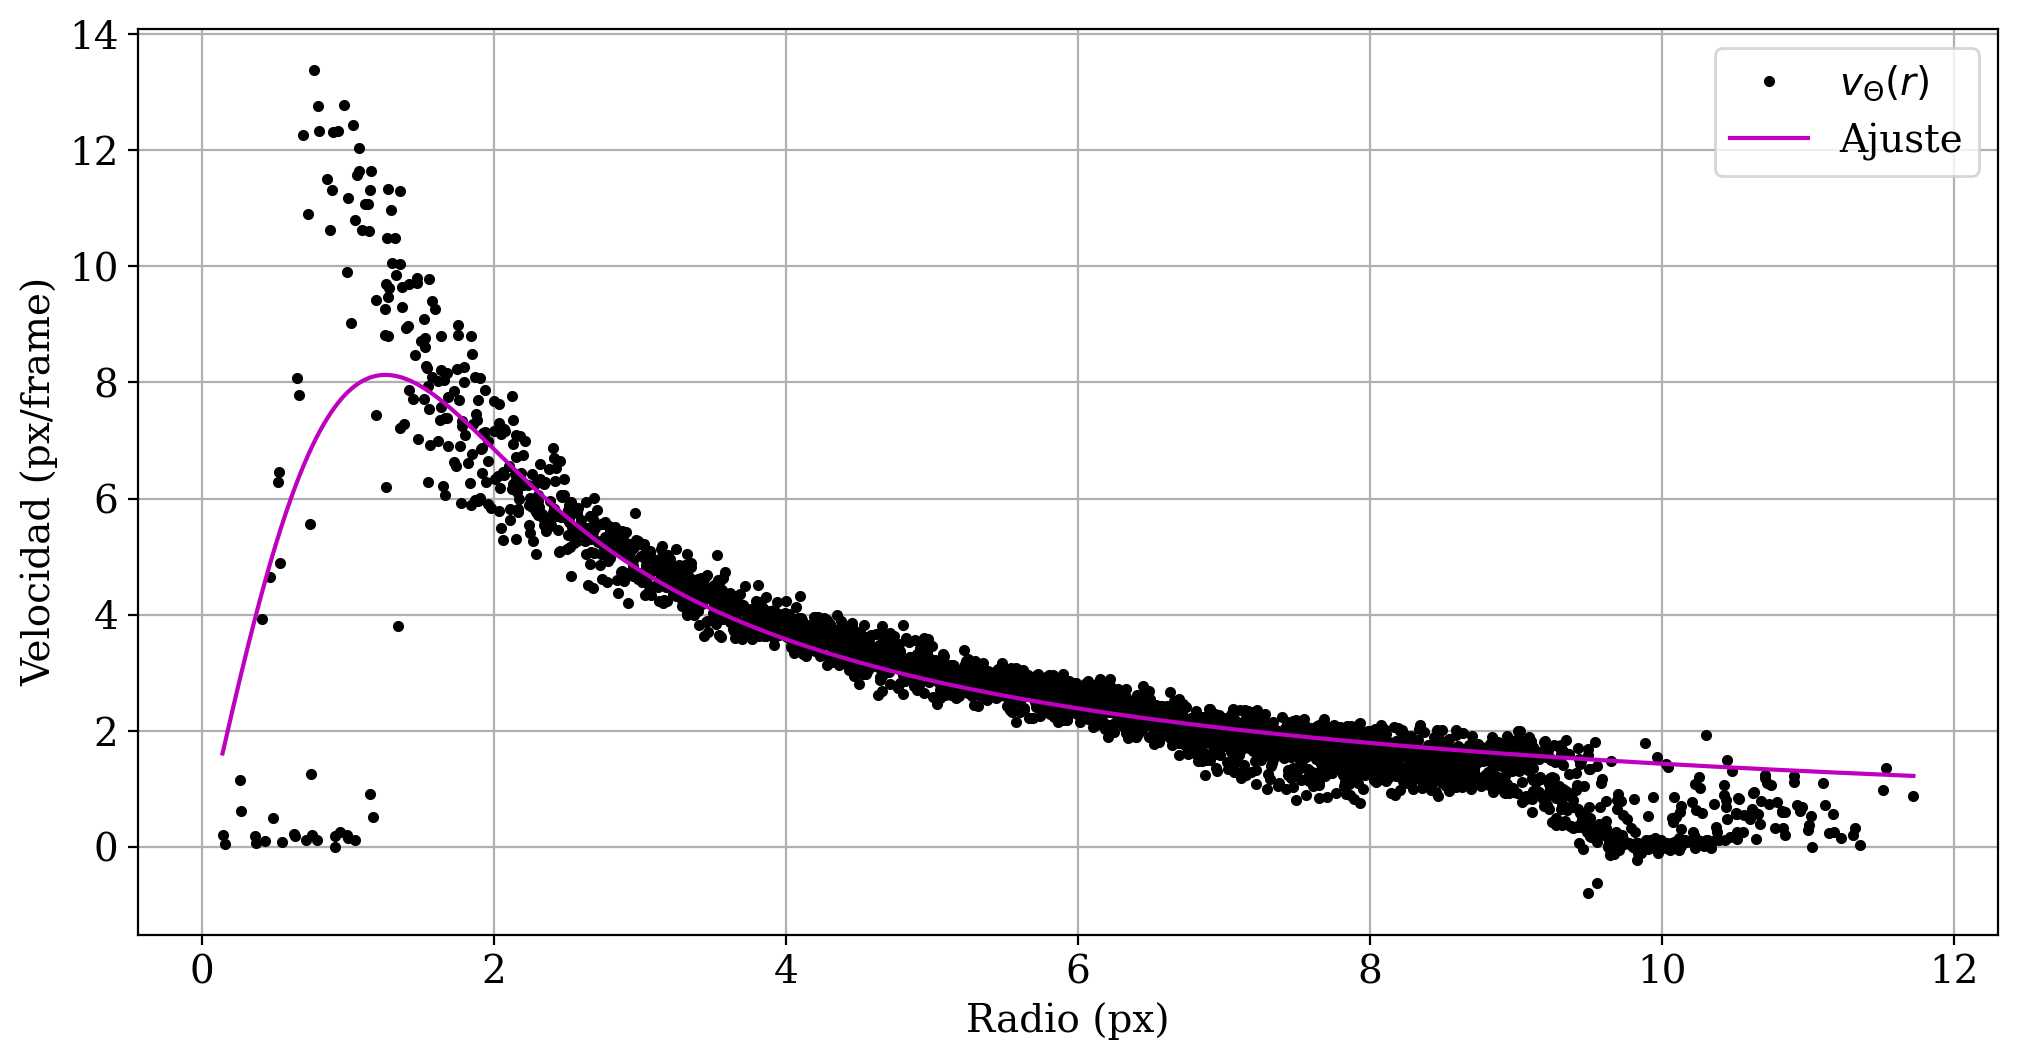

UnboundLocalError: local variable 'omega' referenced before assignment

In [75]:
omega, err_omega, c, err_c, popt = ajuste_sin_errores(burgers,r,v_theta, mostrar_parametros=False)

Ahora graficamos la velocidad en función del ángulo, esto es por completitud, segun ambos modelos, no hay una dependencia en el angulo.

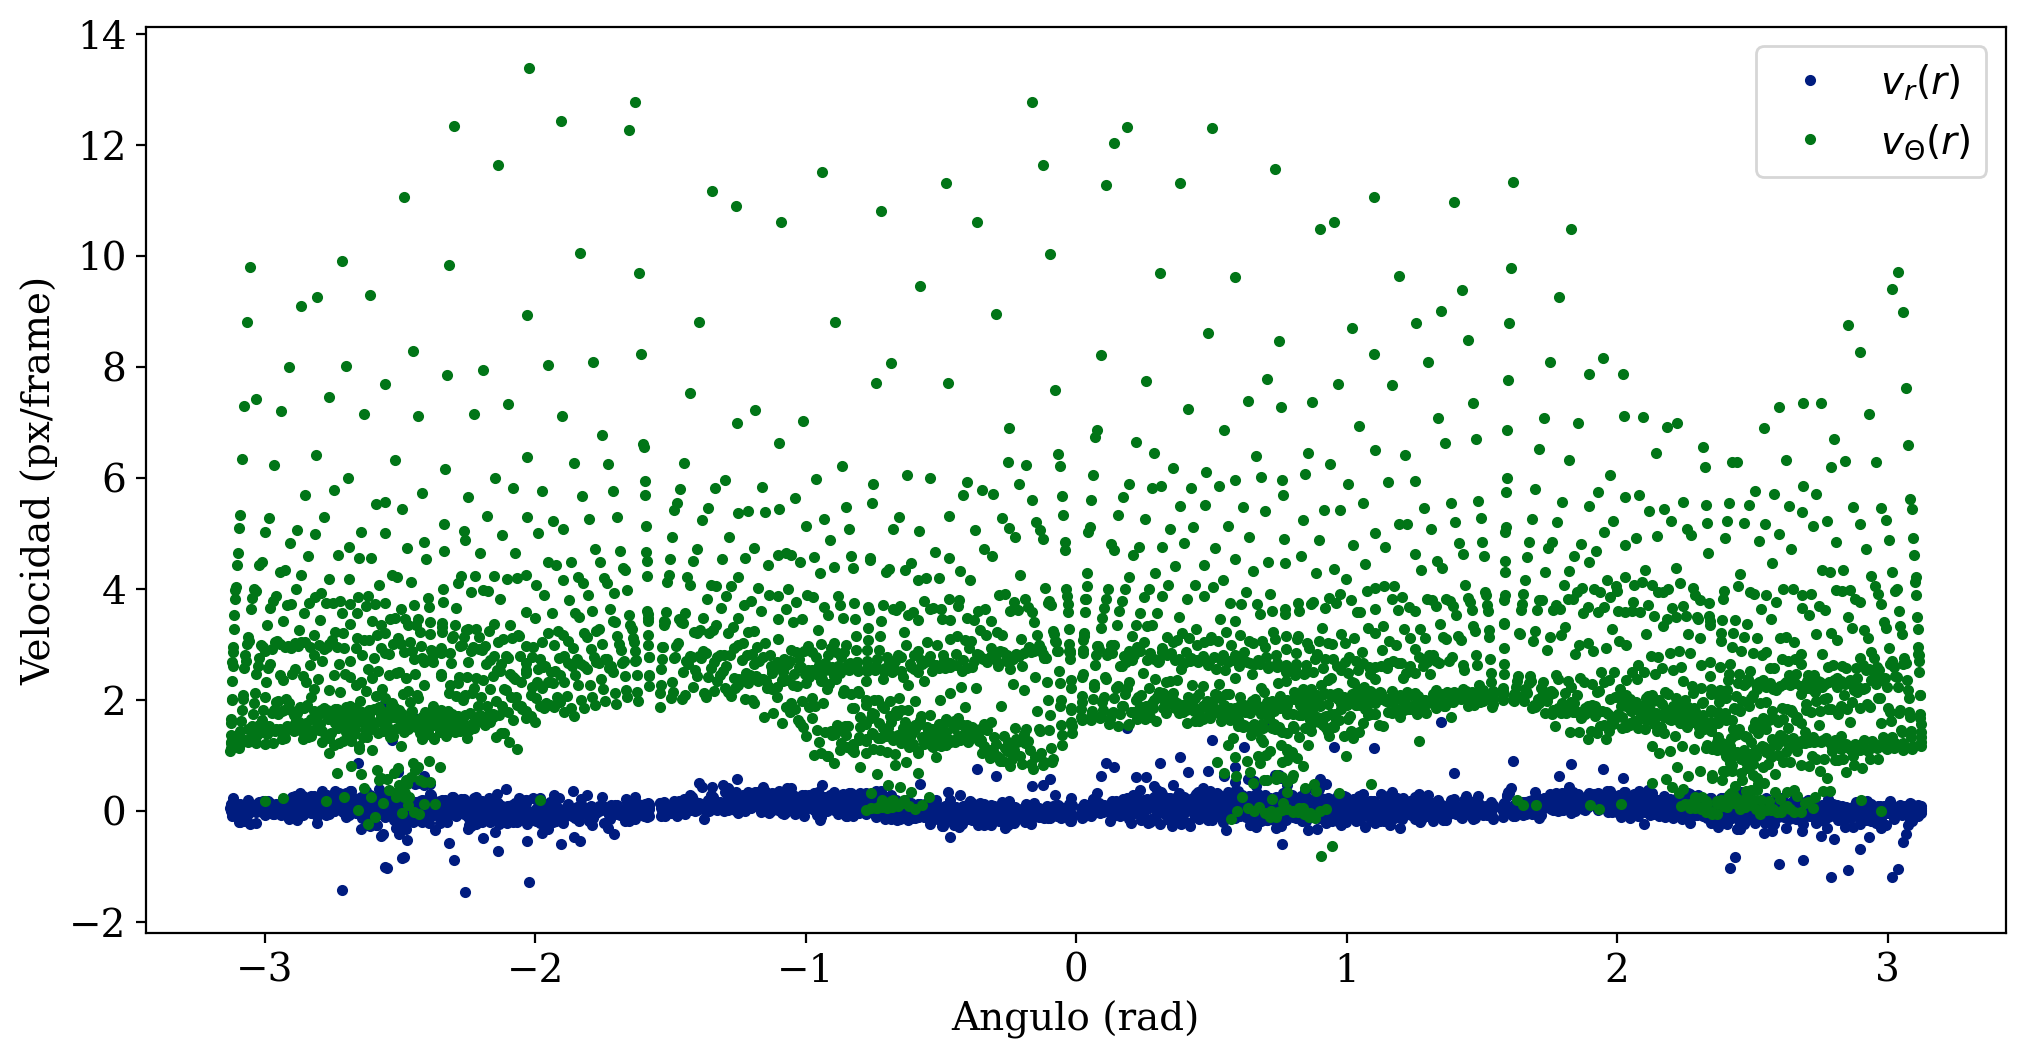

In [70]:
plt.plot(theta,v_r,".",label = "$v_{r}(r)$")
plt.plot(theta,v_theta,".",label = "$v_\Theta(r)$")
plt.xlabel('Angulo (rad)')
plt.ylabel('Velocidad (px/frame)')
plt.legend()
plt.savefig("Velocidades en funcion del angulo")
plt.show()

Ahora pasamos a hacer estadistica sobre los valores, dado que las velocidades nunca tienen exactamente el mismo radio por la capacidad numerica de la computadora, hacemos un promedio en pequeños intervalos.

Primero definimos una funcion para ordenar los datos que tenemos segun el radio, de menor a mayor, para organizarlos mejor.

In [73]:
def promediar(r,v_theta, rango = 0.07):
    
    ordenamiento = sorted(zip(r,v_theta)) # Con esto estamos ordenando las listas de menor a mayor segun el radio, manteniendo la velocidad tangencial de cada valor de r
    r_ord = [i[0] for i in ordenamiento]
    v_t_ord = [i[1] for i in ordenamiento]
    
    r_promedio = [] # Definimos las listas donde guardaremos los promedios
    v_t_promedio = []

    i = 0 # Definimos los iteradores
    j = 0

    while i < len(r_ord): # Empezamos un loop
        l_r_prom = [] # Creamos listas para hacer el promedio entre los valores que esten dentro del rango
        l_v_t_prom = []
        while j < len(r_ord) and r_ord[j] <= r_ord[i] + rango: # Recorremos mientras el j no supere la longitud de r_ord y mientras el r j-esimo sea menor al r i-esimo mas el rango
            # En ese caso, metemos los valores j-esimos en las listas
            l_r_prom.append(r_ord[j])
            l_v_t_prom.append(v_t_ord[j])
            j += 1
        if len(l_r_prom) != 0: # Pedimos que las longitudes de las listas sean distinto de cero ya que sino la suma no funciona
            # Realizamos el promedio de los valores que cumplen el rango
            r_promedio.append(sum(l_r_prom)/len(l_r_prom)) 
            v_t_promedio.append(sum(l_v_t_prom)/len(l_v_t_prom))
        i = j # Ahora como ya recorrimos varios valores con j y no queremos volver a repetirlos, definimos que i arranque desde el ultimo j
    
    return r_promedio, v_t_promedio

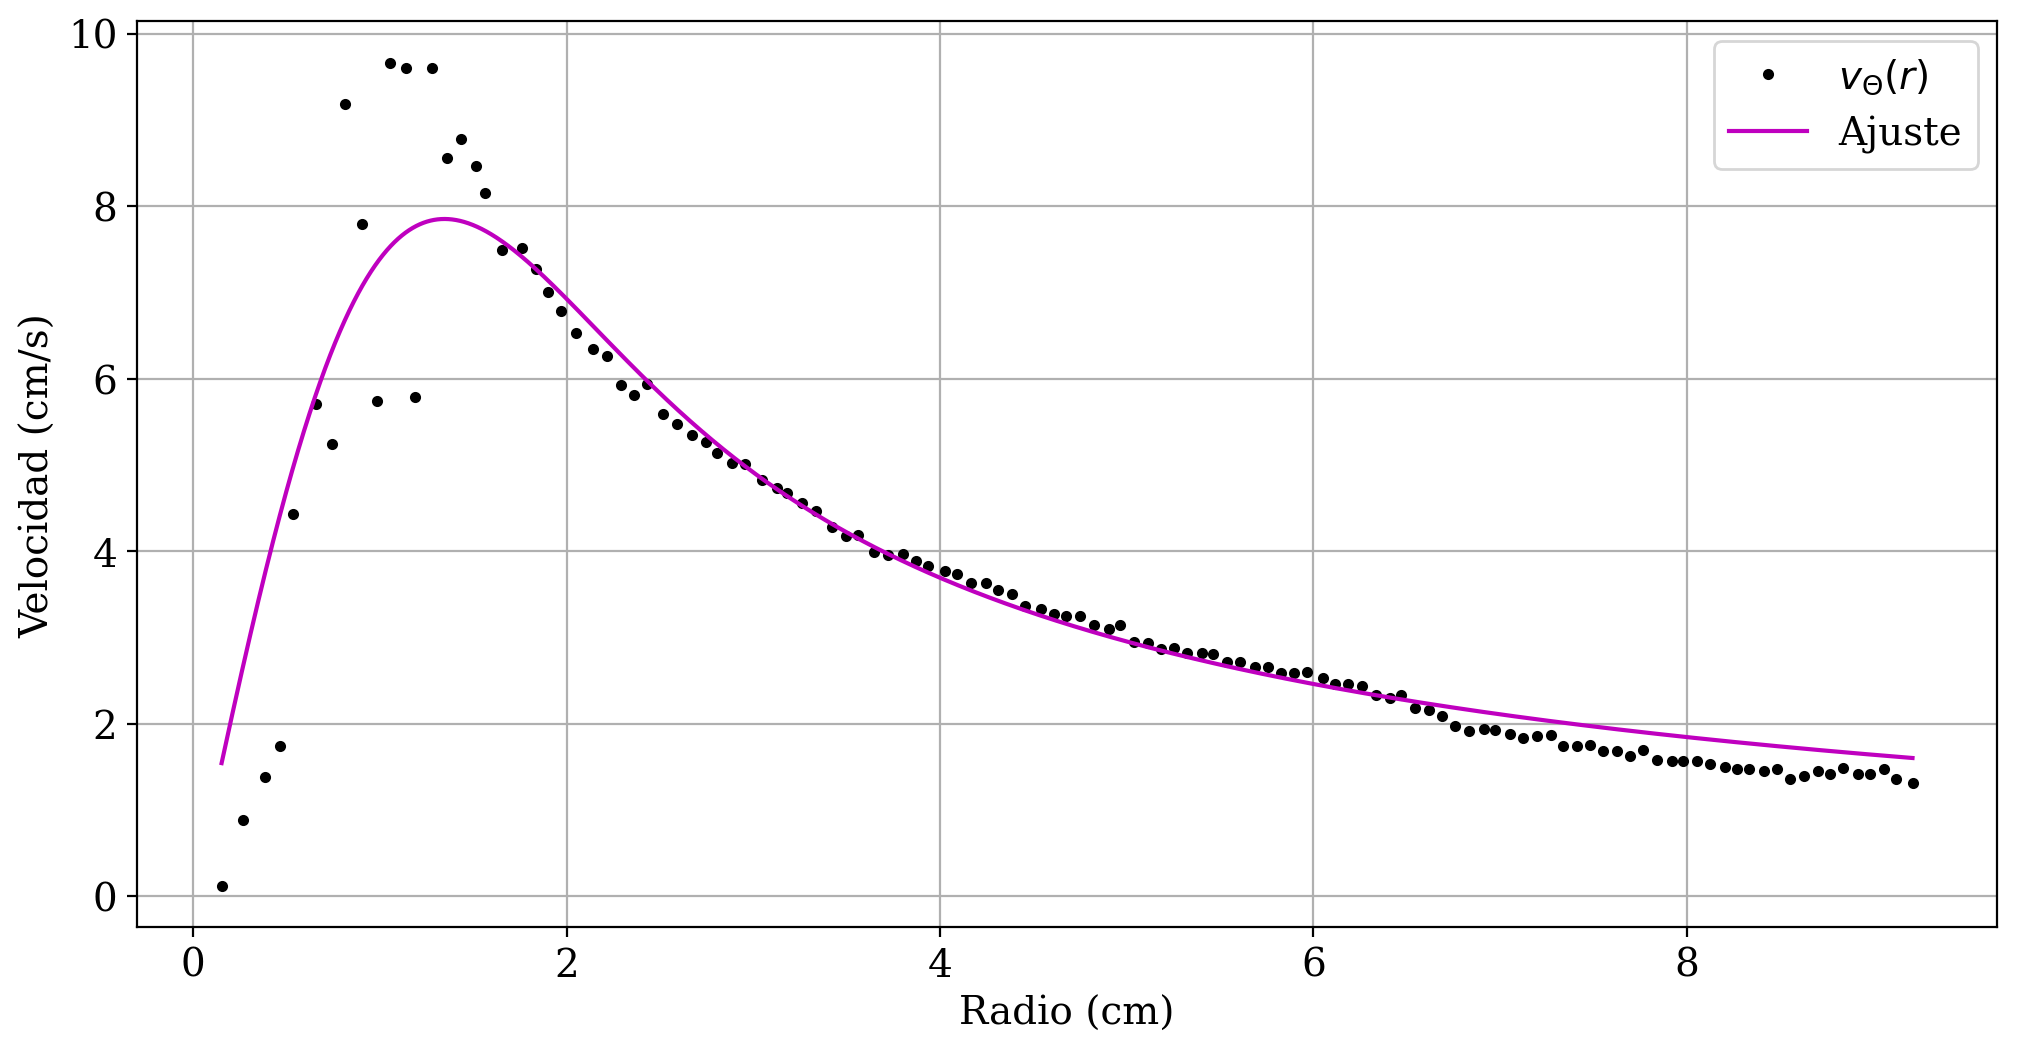

La velocidad angular Omega es 10.246 con error 0.518
El radio del vortice c es -1.201 con error 0.0282
0.8155405398795471


In [95]:
r_promedio, v_t_promedio = promediar(r,v_theta[:])

omega, err_omega, c, err_c, popt = ajuste_sin_errores(burgers,r_promedio[:-28],v_t_promedio[:-28])

residuals = v_theta - burgers(r, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((v_theta-np.mean(v_theta))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

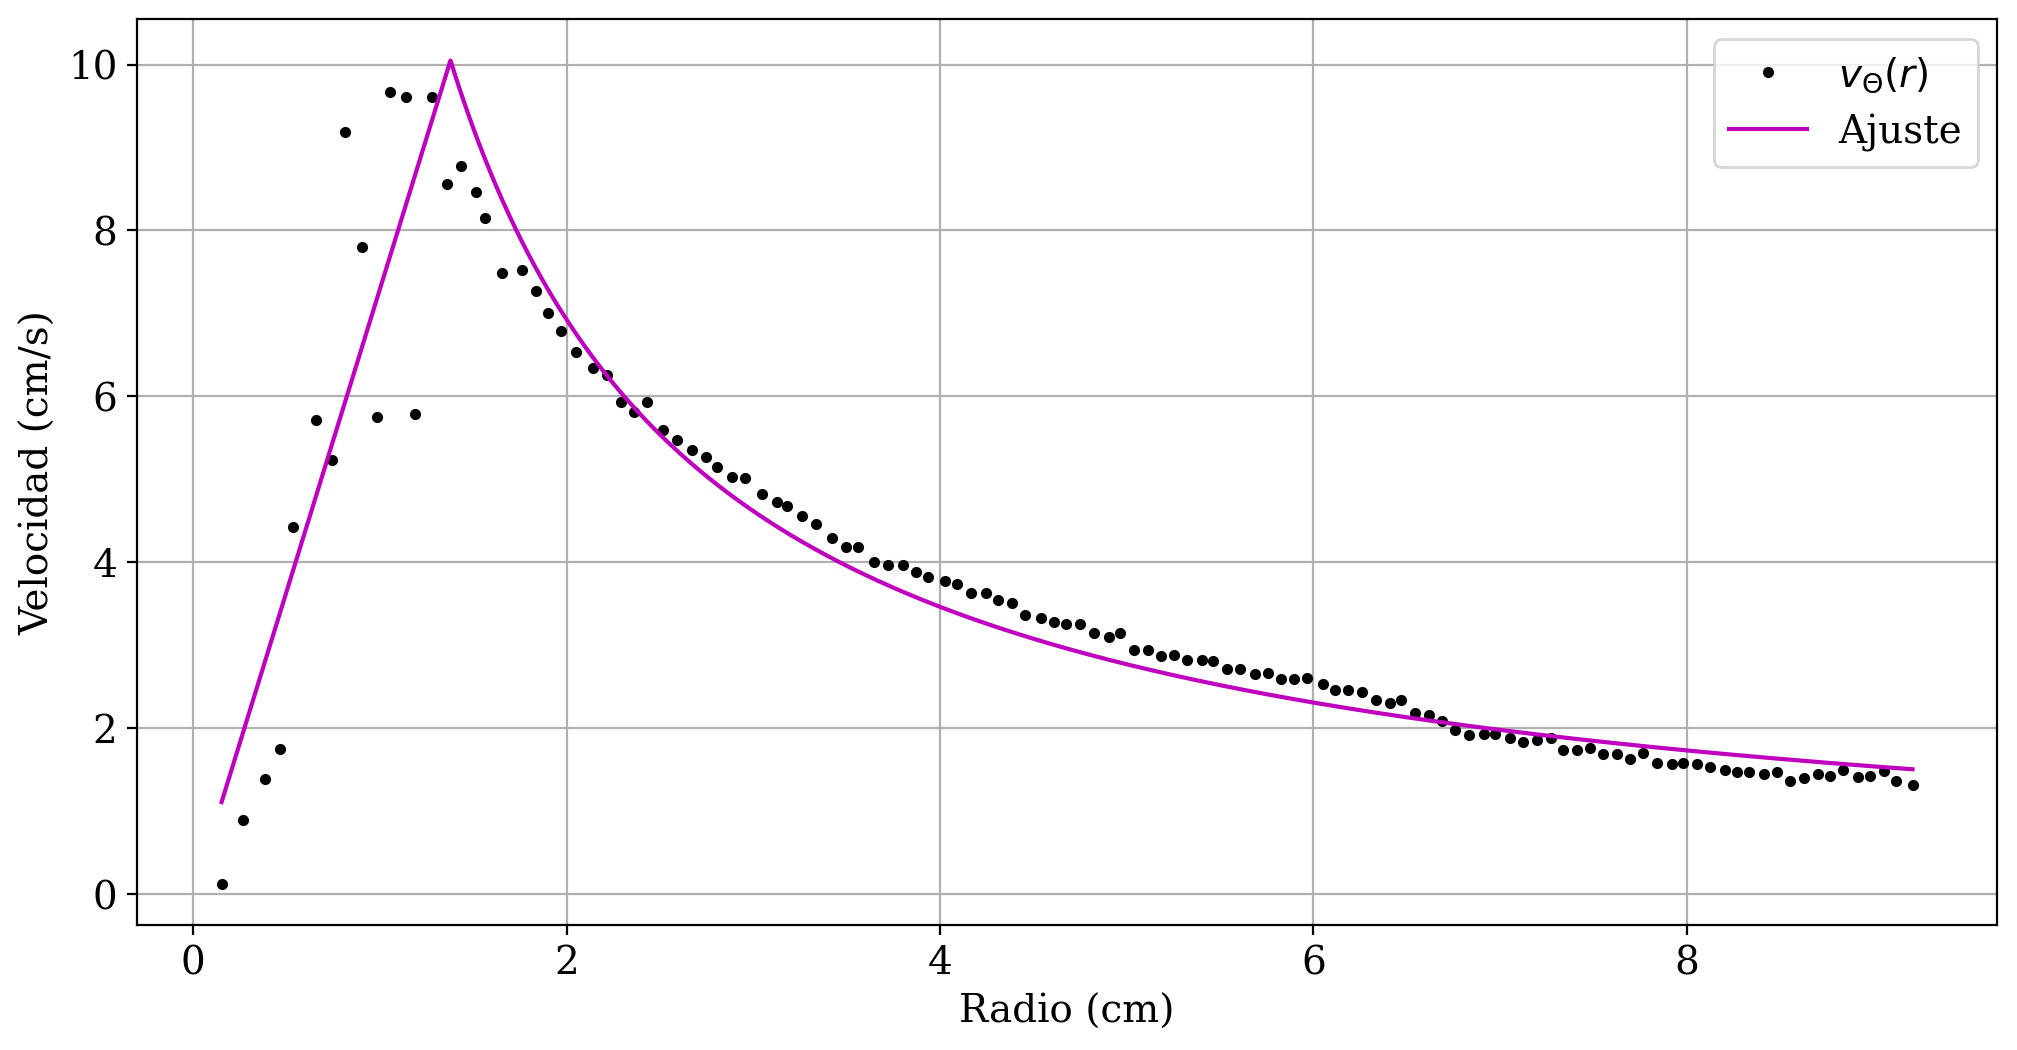

La velocidad angular Omega es 7.294 con error 0.181
El radio del vortice c es 1.378 con error 0.0202
0.8201950909016666


In [94]:
r_promedio, v_t_promedio = promediar(r,v_theta)

omega, err_omega, c, err_c, popt = ajuste_sin_errores(rankine2,r_promedio[:-28],v_t_promedio[:-28])

residuals = v_theta - rankine2(r, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((v_theta-np.mean(v_theta))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)